Number of reference keypoints detected:  500
Number of align image keypoints detected:  489


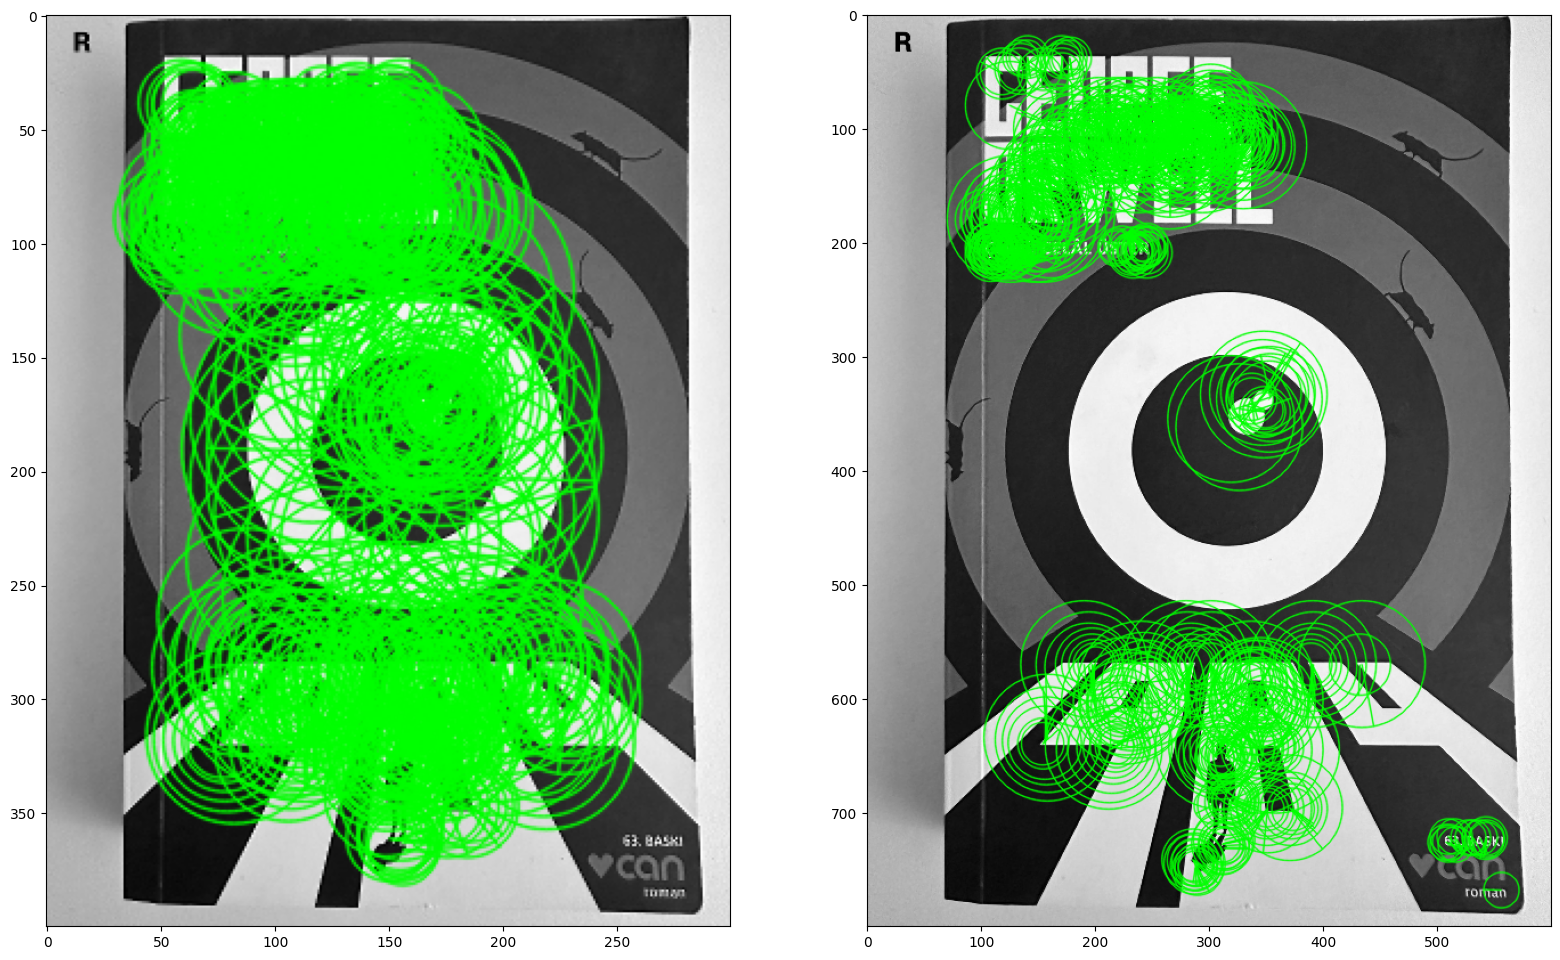

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

def resize_image_with_fixed_height(img, desired_height):

    height, width = img.shape[:2]
    aspect_ratio = width / height
    new_width = int(desired_height * aspect_ratio)

    return cv2.resize(img, (new_width, desired_height))

desired_height = 800

# imgAlign = cv2.imread('./oldImages/george4.jpeg', cv2.IMREAD_GRAYSCALE)
imgReference = cv2.imread('./images/george1e.jpeg', cv2.IMREAD_GRAYSCALE)


imgReference = resize_image_with_fixed_height(imgReference, desired_height)
# imgAlign = resize_image_with_fixed_height(imgAlign, desired_height)

# imgAlign = imutils.rotate_bound(imgReference, 45)
imgAlign = cv2.resize(imgReference, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)

h, w = imgAlign.shape
orb = cv2.ORB_create()

referenceKp, referenceDes = orb.detectAndCompute(imgReference, None)
alignKp, alignDes = orb.detectAndCompute(imgAlign, None)

DimgReference = cv2.drawKeypoints(imgReference, referenceKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
DimgAlign = cv2.drawKeypoints(imgAlign, alignKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print("Number of reference keypoints detected: ", len(referenceKp))
print("Number of align image keypoints detected: ", len(alignKp))

plt.figure(figsize=(30, 30))
plt.subplot(132)
plt.imshow(DimgReference)
plt.subplot(131)
plt.imshow(DimgAlign)
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Number of good matches:  489


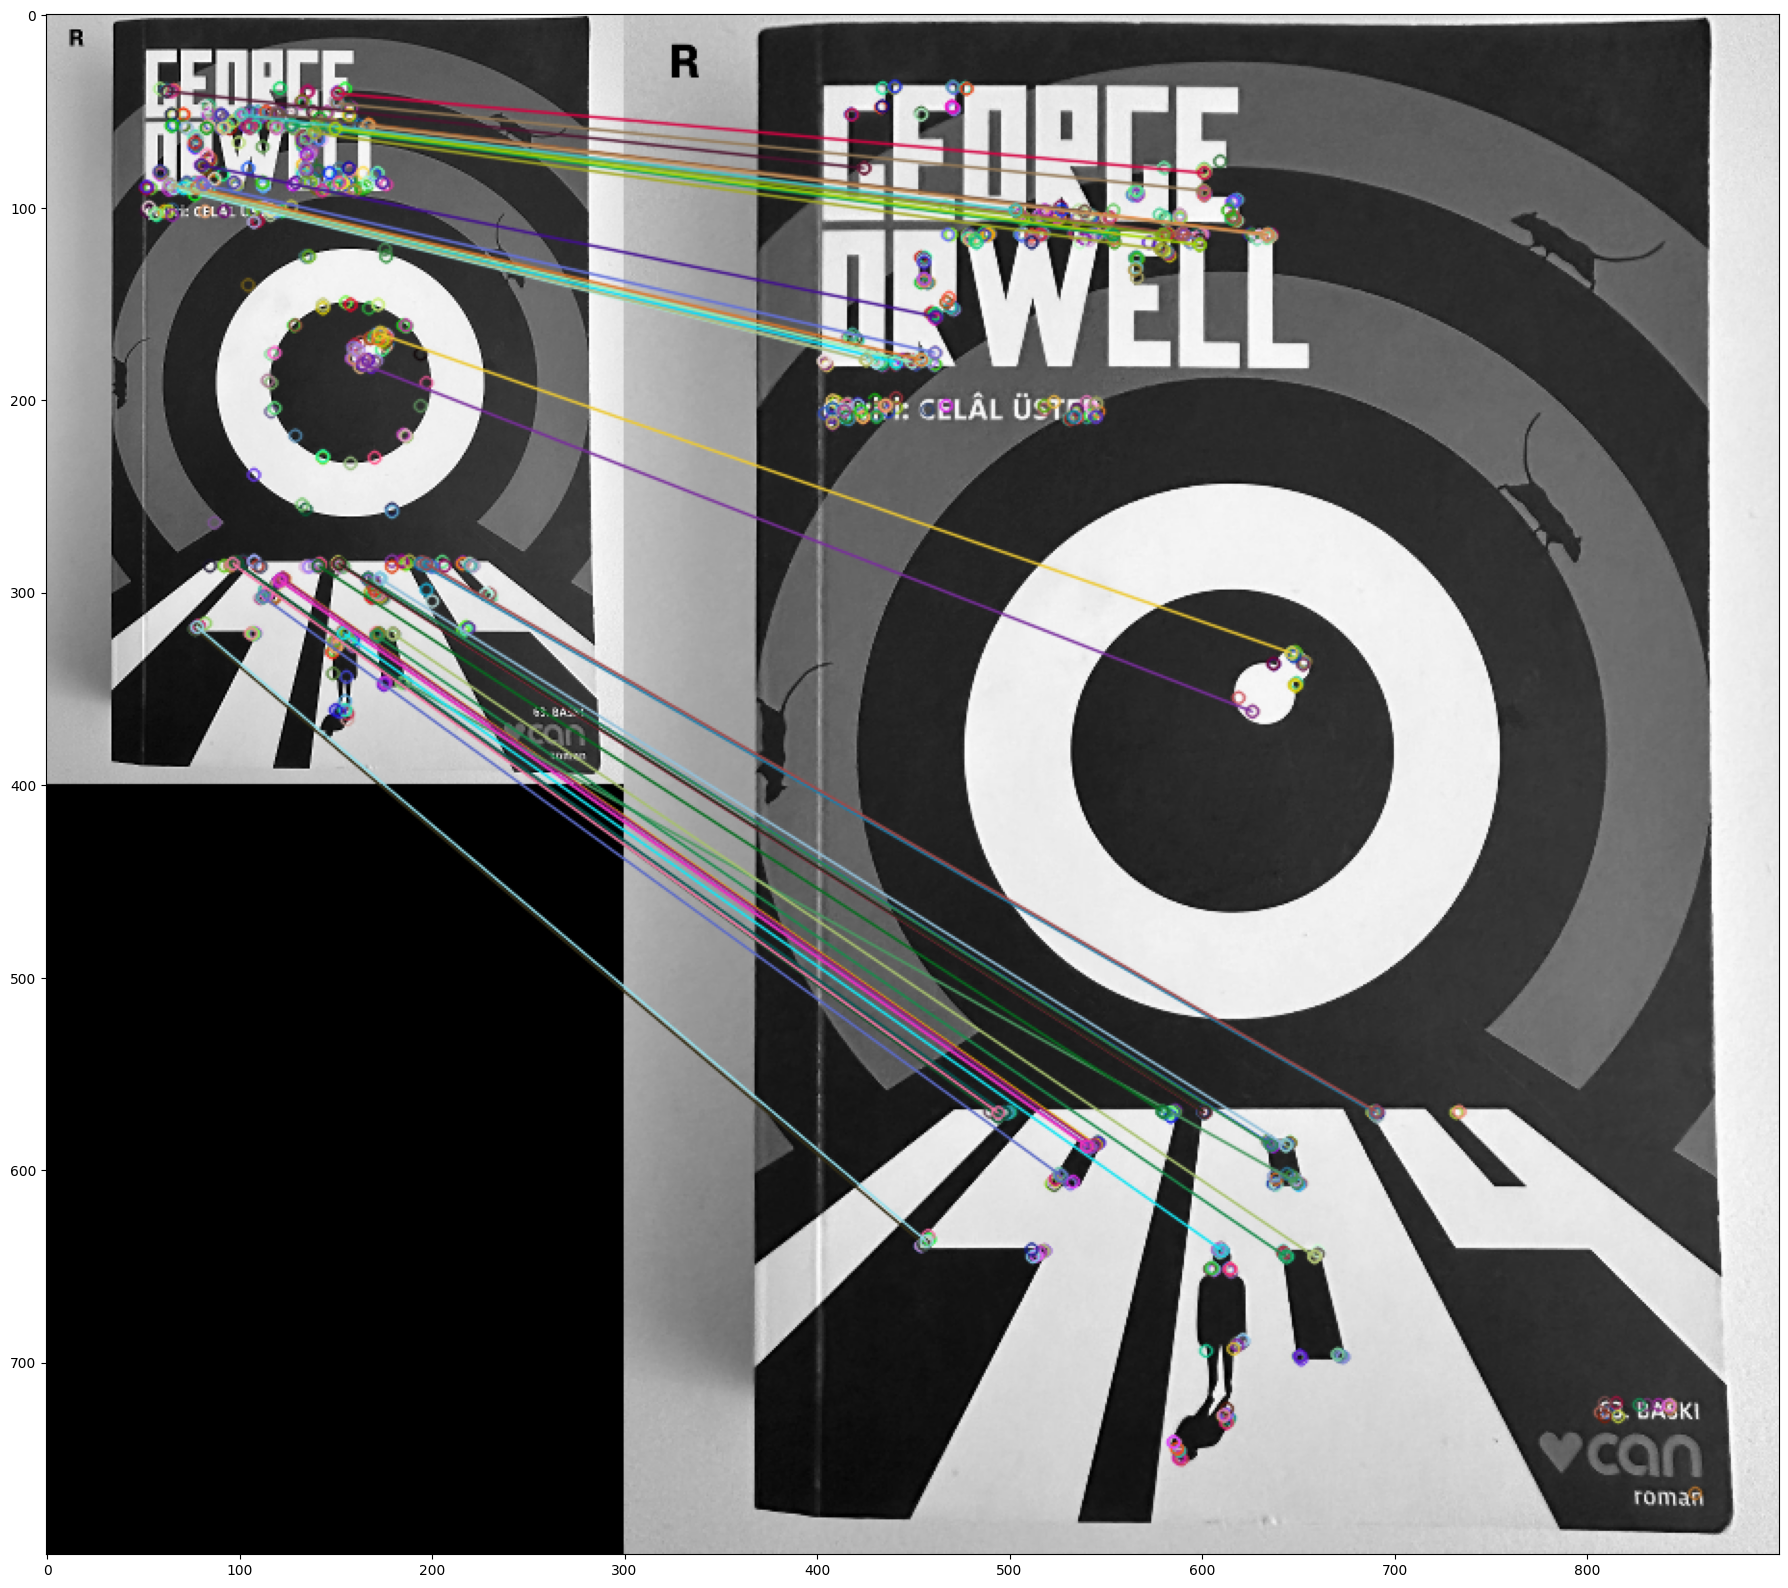

(<matplotlib.image.AxesImage at 0x7f5897545510>, None)

In [76]:
print(type(alignDes))
print(type(referenceDes))


matcher = cv2.BFMatcher()
Matches = matcher.knnMatch(alignDes, referenceDes, k=2)

good = []
for m, n in Matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# print(f"{Matches[0].distance} {Matches[-1].distance}")
print("Number of good matches: ", len(Matches))


matchedImage = cv2.drawMatches(imgAlign, alignKp, imgReference, referenceKp, good, None)
plt.figure(figsize=(30, 20))
plt.imshow(matchedImage, 'gray'), plt.show()

Homografi matrisi: 
[[ 2.00609288e+00 -6.66823788e-03 -1.16262191e+00]
 [-8.53569561e-03  1.98570231e+00  1.77080990e+00]
 [ 1.86348252e-06 -2.48221137e-05  1.00000000e+00]]


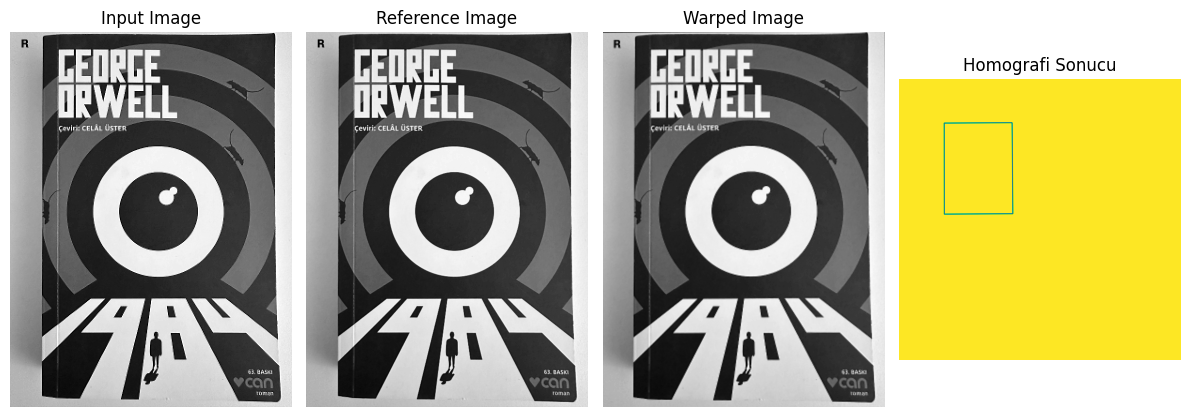

In [77]:
src_pts = []
dst_pts = []

for match in good:
    src_pts.append(alignKp[match.queryIdx].pt)
    dst_pts.append(referenceKp[match.trainIdx].pt)

src_pts = np.float32(src_pts).reshape(-1, 1, 2)
dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

if M is None:
    print("Homografi bulunamadı.")

print(f"Homografi matrisi: \n{M}")

offset_x = 200
offset_y = 200

pts = np.float32([
    [0 + offset_x, 0 + offset_y],
    [0 + offset_x, h - 1 + offset_y],
    [w - 1 + offset_x, h - 1 + offset_y],
    [w - 1 + offset_x, 0 + offset_y]
]).reshape(-1, 1, 2)

dst = cv2.perspectiveTransform(pts, M)

im1_reg = cv2.warpPerspective(imgAlign, M, (imgReference.shape[1], imgReference.shape[0]))

empty_frame = np.ones((2500, 2500), dtype=np.uint8) * 255
empty_frame = cv2.polylines(empty_frame, [np.int32(dst)], True, 122, 3, cv2.LINE_AA)


plt.figure(figsize=(12, 6))
plt.subplot(141), plt.imshow(imgAlign, cmap='gray')
plt.title('Input Image'), plt.axis('off')

plt.subplot(142), plt.imshow(imgReference, cmap='gray')
plt.title('Reference Image'), plt.axis('off')

plt.subplot(143), plt.imshow(im1_reg, cmap='gray')
plt.title('Warped Image'), plt.axis('off')

plt.subplot(144), plt.imshow(empty_frame)
plt.title('Homografi Sonucu'), plt.axis('off')


plt.tight_layout()
plt.show()
